#### Import packages

In [1]:
# import torch.multiprocessing as mp
# mp.set_start_method('spawn') 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import shutil
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import random
import cv2

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tensorboardX import SummaryWriter
import torch.utils.data
import torch.utils.data as data_utils

seed = 0
# random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
np.random.seed(seed)
from utils import *

#### Load and Prepare Data

In [3]:
data = pd.read_json('./Data/train.json')
test = pd.read_json('./Data/test.json')

In [5]:
data['band_1'] = data['band_1'].apply(lambda x : np.array(x).reshape(75, 75))
data['band_2'] = data['band_2'].apply(lambda x : np.array(x).reshape(75, 75))

test['band_1'] = test['band_1'].apply(lambda x : np.array(x).reshape(75, 75))
test['band_2'] = test['band_2'].apply(lambda x : np.array(x).reshape(75, 75))

data['inc_angle'] = pd.to_numeric(data['inc_angle'], errors='coerce').fillna(0.0)
test['inc_angle'] = pd.to_numeric(test['inc_angle'], errors='coerce')

train, val = train_test_split(data, test_size=0.2, random_state=42)

In [6]:
band_1_tr = np.concatenate([im for im in train['band_1']]).reshape(-1, 75, 75)
band_2_tr = np.concatenate([im for im in train['band_2']]).reshape(-1, 75, 75)
X_train = np.stack((band_1_tr, band_2_tr), axis=1)
X_train = [X_train, np.array(train['inc_angle']).reshape((len(train), 1))]

band_1_val = np.concatenate([im for im in val['band_1']]).reshape(-1, 75, 75)
band_2_val = np.concatenate([im for im in val['band_2']]).reshape(-1, 75, 75)
X_val = np.stack((band_1_val, band_2_val), axis=1)
X_val = [X_val, np.array(val['inc_angle']).reshape((len(val), 1))]

band_1_test = np.concatenate([im for im in test['band_1']]).reshape(-1, 75, 75)
band_2_test = np.concatenate([im for im in test['band_2']]).reshape(-1, 75, 75)
rgb = np.stack((band_1_test, band_2_test), axis=1)
X_test = [rgb, np.array(test['inc_angle']).reshape((len(test), 1))]

y_train = train['is_iceberg'].values.astype(np.float32)
y_val = val['is_iceberg'].values.astype(np.float32)

#### PyTorch Model

In [7]:
# Hyper Parameters
width = 65
height = 65
channels = 2
padding = 1

In [8]:
# Data Loader (Input Pipeline)
class icebergDataset(data_utils.Dataset):
    """Iceberg-Ship dataset."""

    def __init__(self, X, y=None, transform=None, eval_=None):
        self.X_images = X[0]
        self.X_angles = torch.from_numpy(X[1]).float()
        if y!=None:
            self.y = torch.from_numpy(y).long()
        else:
            self.y=None
        self.transform = transform
        self.eval = eval_

    def __len__(self):
        return len(self.X_images)

    def __getitem__(self, idx):
        im = self.X_images[idx]
        if self.transform:
#             if np.random.random() < 0.2:
#                 im = cv2.blur(im, (2,2))
            im = randomErodeDilate(im, u=0.2)
            im = randomZoomOut(im, u=0.5)
            if np.random.randint(2) == 1:
                im = randomNoisy(im, u=0.8)
            else:
                im = randomDenoising(im, u=0.8)
#             im = randomShift(im, u=0.3)
        
        # Get patch
        if self.eval:
            ims = []
            for patch_num in range(10):                
                im_sw = np.random.randint(im.shape[1]-1-65)
                im_sh = np.random.randint(im.shape[2]-1-65)
                ims.append(torch.from_numpy(im[:, im_sw:im_sw+65, im_sh:im_sh+65]).float())
            features = torch.stack(ims)
            features_angle = self.X_angles[idx]
        else:
            im_sw = np.random.randint(im.shape[1]-1-65)
            im_sh = np.random.randint(im.shape[2]-1-65)
            im = im[:, im_sw:im_sw+65, im_sh:im_sh+65]
            features = torch.from_numpy(im).float()
            features_angle = self.X_angles[idx]
        
        try:
            if self.y==None:
                return [features, features_angle]
        except:
            pass
        
        return [features, features_angle, self.y[idx]]

In [9]:
def save_checkpoint(state, is_best, filename='./Models/checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, './Models/model_best.pth.tar')

In [10]:
train_dataset = icebergDataset(X_train, y_train, transform=True)
val_dataset = icebergDataset(X_val, y_val, eval_=True)
test_dataset = icebergDataset(X_test, eval_=True)

/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [13]:
k = 12
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.batch = nn.BatchNorm2d(channels)
        self.batch1D = nn.BatchNorm1d(1)
        
        # MyNet
        self.layer1 = nn.Sequential(
            nn.Conv2d(channels, 9, kernel_size=3, padding=padding),
            nn.BatchNorm2d(9),
            nn.ReLU(),
            nn.Conv2d(9, 18, kernel_size=3, padding=padding),
            nn.BatchNorm2d(18),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0))
        self.layer2 = nn.Sequential(
            nn.Conv2d(18, 24, kernel_size=3, padding=padding),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Conv2d(24, 36, kernel_size=3, padding=padding),
            nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0))
        self.layer3 = nn.Sequential(
            nn.Conv2d(36, 72, kernel_size=2, padding=padding),
            nn.BatchNorm2d(72),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0))
        self.layer4 = nn.Sequential(
            nn.Conv2d(72, 144, kernel_size=2, padding=padding),
            nn.BatchNorm2d(144),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0))
        self.layer_shallow = nn.Sequential(
            nn.Conv2d(channels, 128, kernel_size=3, padding=padding),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2))
        self.fc1 = nn.Sequential(
            nn.Linear(1+(4*4*144), 512),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.fc2 = nn.Sequential(
            nn.Linear(512, 196),
            nn.ReLU(),
            nn.Dropout(0.3))
        self.fc3 = nn.Linear(196, 2)
        
        # DenseNet
        self.init = nn.Sequential(
            nn.Conv2d(channels, k*2, kernel_size=3, padding=padding),
            nn.BatchNorm2d(k*2),
            nn.ReLU(),
            nn.Dropout(0))
        self.b1l1 = nn.Sequential(
            nn.Conv2d(k*2, k, kernel_size=3, padding=padding),
            nn.BatchNorm2d(k),
            nn.ReLU(),
            nn.Dropout(0))
        self.b1l2 = nn.Sequential(
            nn.Conv2d(k*3, k, kernel_size=3, padding=padding),
            nn.BatchNorm2d(k),
            nn.ReLU(),
            nn.Dropout(0))
        self.transition1 = nn.Sequential(
            nn.Conv2d(k*4, k*4, kernel_size=1, padding=0),
            nn.BatchNorm2d(k*4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0))
        self.b2l1 = nn.Sequential(
            nn.Conv2d(k*4, k, kernel_size=2, padding=0),
            nn.BatchNorm2d(k),
            nn.ReLU(),
            nn.Dropout(0))
        self.b2l2 = nn.Sequential(
            nn.Conv2d(k*5, k, kernel_size=2, padding=0),
            nn.BatchNorm2d(k),
            nn.ReLU(),
            nn.Dropout(0))
        self.transition2 = nn.Sequential(
            nn.Conv2d(k*6, k*6, kernel_size=1, padding=0),
            nn.BatchNorm2d(k*6),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0))
        self.b3l1 = nn.Sequential(
            nn.Conv2d(k*6, k, kernel_size=2, padding=0),
            nn.BatchNorm2d(k),
            nn.ReLU(),
            nn.Dropout(0))
        self.b3l2 = nn.Sequential(
            nn.Conv2d(k*7, k, kernel_size=2, padding=0),
            nn.BatchNorm2d(k),
            nn.ReLU(),
            nn.Dropout(0))
        self.transition3 = nn.Sequential(
            nn.Conv2d(k*8, k*8, kernel_size=1, padding=0),
            nn.BatchNorm2d(k*8),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0))
        self.denselayer3 = nn.Sequential(
            nn.Conv2d(k*8, k*6, kernel_size=2, padding=0),
            nn.BatchNorm2d(k*6),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0))
        self.denselayer4 = nn.Sequential(
            nn.Conv2d(k*6, k*4, kernel_size=2, padding=0),
            nn.BatchNorm2d(k*4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0))
        self.densefc1 = nn.Sequential(
            nn.Linear(1+(3*3*k*6), 512),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.densefc2 = nn.Sequential(
            nn.Linear(512, 196),
            nn.ReLU(),
            nn.Dropout(0.3))
        self.densefc3 = nn.Linear(196, 2)
        
        # Ensemble
        self.ensemble = nn.Linear(4, 2)
        
        
    def forward(self, x_im, x_angle):
        x_im = self.batch(x_im)
        x_angle = self.batch1D(x_angle)
        
        # MyNet
        out = self.layer1(x_im)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
#         out_shallow = self.layer_shallow(x_im)
#         out_shallow  = F.max_pool2d(out_shallow, kernel_size=out_shallow.size()[2:])
#         out_shallow = out_shallow.view(out_shallow.size(0), -1)
        out = torch.cat([out, x_angle], dim=1)
        out = self.fc1(out)
        out = self.fc2(out)
        out_MyNet = self.fc3(out)
        
        # DenseNet
        out_prev = self.init(x_im)
        out = self.b1l1(out_prev)
        out_prev = torch.cat([out, out_prev], dim=1)
        out = self.b1l2(out_prev)
        out_prev = torch.cat([out, out_prev], dim=1)
        out_prev = self.transition1(out_prev)
        out = self.b2l1(out_prev)
        out_prev = torch.cat([F.pad(out, (0,1,0,1), "constant", 0), out_prev], dim=1)
        out = self.b2l2(out_prev)
        out_prev = torch.cat([F.pad(out, (0,1,0,1), "constant", 0), out_prev], dim=1)
        out_prev = self.transition2(out_prev)
        out = self.b3l1(out_prev)
        out_prev = torch.cat([F.pad(out, (0,1,0,1), "constant", 0), out_prev], dim=1)
        out = self.b3l2(out_prev)
        out_prev = torch.cat([F.pad(out, (0,1,0,1), "constant", 0), out_prev], dim=1)
        out_prev = self.transition3(out_prev)
        out = self.denselayer3(out_prev)
#         out = self.layer4(out)
        out = out.view(out.size(0), -1)
#         out_shallow = self.layer_shallow(x_im)
#         out_shallow  = F.max_pool2d(out_shallow, kernel_size=out_shallow.size()[2:])
#         out_shallow = out_shallow.view(out_shallow.size(0), -1)
        out = torch.cat([out, x_angle], dim=1)
        out = self.densefc1(out)
        out = self.densefc2(out)
        out_DenseNet = self.densefc3(out)
        
        # Ensemble
        out = torch.cat([out_MyNet, out_DenseNet], dim=1)
        out = self.ensemble(out)
        return out

In [44]:
def weight_init(m): 
    if isinstance(m, nn.Conv2d):
        size = m.weight.size()
        fan_out = size[0] # number of rows
        fan_in = size[1] # number of columns
        variance = np.sqrt(3.0/(fan_in + fan_out))
        m.weight.data.normal_(0.0, variance)

In [25]:
writer = SummaryWriter()
iceNet = net()
iceNet.apply(weight_init)
iceNet.cuda()

net (
  (batch): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True)
  (batch1D): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True)
  (layer1): Sequential (
    (0): Conv2d(2, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): Conv2d(9, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU ()
    (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (7): Dropout (p = 0)
  )
  (layer2): Sequential (
    (0): Conv2d(18, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): Conv2d(24, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU ()
    (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (7): Dropout (p = 0)
  )
  (layer3)

In [15]:
num_epochs = 200
batch_size = 32
learning_rate = 0.001

In [16]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(iceNet.parameters(), lr=learning_rate, weight_decay=0.0001)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

def accuracy(loader):
    iceNet.eval()
    correct = 0
    total = 0
    loss = []
    for features, features_angle, labels in loader:
        features = features.cuda()
        labels = labels.cuda()
        features_angle = features_angle.cuda()
        features = Variable(features, volatile=True)
        features_angle = Variable(features_angle, volatile=True)
        labels = Variable(labels, volatile=True)
        outputs = []
        for patch_num in range(features.size()[1]):
            patch_features = features[:,patch_num,:,:].contiguous()
            outputs.append(iceNet(patch_features, features_angle))
        outputs = torch.stack(outputs)
        outputs = torch.mean(outputs, 0)
        _loss = criterion(outputs, labels)
        loss.append(_loss)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
        
    return np.mean(loss).data[0], (100 * correct / total)

In [17]:
# Train the Model
best_prec1 = 1
for epoch in range(num_epochs):
    epoch_train_loss = []
    for i, (features, features_angle, labels) in enumerate(train_loader):
        iceNet.train()
        features = features.cuda()
        labels = labels.cuda()
        features = Variable(features).float()
        features_angle = Variable(features_angle).cuda()
        labels = Variable(labels).long()
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = iceNet(features, features_angle)
        writer.add_graph(iceNet, outputs)
        loss = criterion(outputs, labels)
        epoch_train_loss.append(loss)
        loss.backward()
        optimizer.step()
        
    prec1 = accuracy(val_loader)[0]
    print ('Epoch [%d/%d] \nTraining Loss: %.4f' % (epoch+1, num_epochs, np.mean(epoch_train_loss).data[0]))
    print('Validation Loss: %.4f, Accuracy: %.2f%%' % accuracy(val_loader))
    
    is_best = prec1 < best_prec1
    best_prec1 = min(prec1, best_prec1)
#     save_checkpoint({
#         'epoch': epoch + 1,
#         'state_dict': iceNet.state_dict(),
#         'best_prec1': best_prec1,
#         'optimizer' : optimizer.state_dict(),
#     }, is_best)

print(best_prec1)
# export scalar data to JSON for external processing
writer.close()

Epoch [1/200] 
Training Loss: 0.6377
Validation Loss: 0.4597, Accuracy: 74.45%
Epoch [2/200] 
Training Loss: 0.5033
Validation Loss: 0.3481, Accuracy: 82.87%
Epoch [3/200] 
Training Loss: 0.4819
Validation Loss: 0.3197, Accuracy: 85.05%
Epoch [4/200] 
Training Loss: 0.4462
Validation Loss: 0.2693, Accuracy: 86.92%
Epoch [5/200] 
Training Loss: 0.4369
Validation Loss: 0.3056, Accuracy: 85.05%
Epoch [6/200] 
Training Loss: 0.3996
Validation Loss: 0.2722, Accuracy: 87.85%
Epoch [7/200] 
Training Loss: 0.3881
Validation Loss: 0.2752, Accuracy: 86.29%
Epoch [8/200] 
Training Loss: 0.3506
Validation Loss: 0.2474, Accuracy: 89.72%
Epoch [9/200] 
Training Loss: 0.3258
Validation Loss: 0.2680, Accuracy: 87.23%
Epoch [10/200] 
Training Loss: 0.3414
Validation Loss: 0.3527, Accuracy: 82.87%
Epoch [11/200] 
Training Loss: 0.3558
Validation Loss: 0.2267, Accuracy: 88.79%
Epoch [12/200] 
Training Loss: 0.3154
Validation Loss: 0.2966, Accuracy: 86.60%
Epoch [13/200] 
Training Loss: 0.3178
Validation 

KeyboardInterrupt: 

In [ ]:
print("=> loading checkpoint")
best_model = torch.load('./Models/model_best.pth.tar')
print('best_prec1 = ', best_model['best_prec1'])
iceNet.load_state_dict(best_model['state_dict'])
optimizer.load_state_dict(best_model['optimizer'])

In [124]:
temp_dataset = icebergDataset(X_train)

In [129]:
# Predict
iceNet.eval()
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
results = []
for features, features_angle in test_loader:
    iceNet.eval()
    features = Variable(features, volatile=True).cuda()
    features_angle = Variable(features_angle, volatile=True).cuda()
    outputs = F.softmax(iceNet(features, features_angle))
#     outputs = iceNet(features, features_angle)

    results.append(outputs.data[0][1])

In [126]:
sum(y_train>0.5)/len(y_train)

0.45908028059236167

In [130]:
sum(np.array(results)>0.5)/len(results)

0.30282526115859448

In [131]:
results[:50]

[0.02592930756509304,
 0.3247637450695038,
 1.0454600713242189e-14,
 0.9999004602432251,
 0.40994328260421753,
 0.6011435389518738,
 0.024099018424749374,
 0.9999616146087646,
 2.8529889561923483e-10,
 2.0306337167319555e-10,
 1.0756996557609658e-15,
 0.30658578872680664,
 1.2682083252002485e-05,
 0.29034730792045593,
 4.115712783914205e-07,
 0.0020702641922980547,
 0.0006665511173196137,
 0.001083467504940927,
 0.003712332108989358,
 0.9074830412864685,
 0.02027943916618824,
 0.18286937475204468,
 0.23720575869083405,
 0.12182788550853729,
 3.2119743469767245e-14,
 7.707850357974166e-09,
 0.007208712864667177,
 0.4834314286708832,
 0.1449306458234787,
 0.9999291896820068,
 1.087272768563255e-13,
 0.6034151315689087,
 0.4970799684524536,
 0.016889972612261772,
 0.7639496326446533,
 0.9922479391098022,
 0.0013621319085359573,
 0.2865104377269745,
 0.28295210003852844,
 0.8613411784172058,
 3.21758954014231e-15,
 0.5548590421676636,
 0.8960628509521484,
 2.0677757675002795e-06,
 0.616992

In [132]:
sub = pd.read_csv('./Data/sample_submission.csv')

In [133]:
sub['is_iceberg'] = results

In [135]:
sub.to_csv('./Submissions/sub_30Oct_val_1631.csv', index=False)

#### KFold

In [32]:
band_1_KF = np.concatenate([im for im in data['band_1']]).reshape(-1, 75, 75)
band_2_KF = np.concatenate([im for im in data['band_2']]).reshape(-1, 75, 75)
rgb = np.stack((band_1_KF, band_2_KF), axis=1)
X_KF = [rgb, np.array(data['inc_angle']).reshape((len(data), 1))]

y_KF = data['is_iceberg'].values.astype(np.float32)

In [33]:
def accuracy(loader):
    iceNet.eval()
    correct = 0
    total = 0
    loss = []
    for features, features_angle, labels in loader:
        features = Variable(features, volatile=True).cuda()
        features_angle = Variable(features_angle, volatile=True).cuda()
        labels = Variable(labels, volatile=True).cuda()
        outputs = iceNet(features, features_angle)
        _loss = criterion(outputs, labels)
        loss.append(_loss)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
        
    return np.mean(loss).data[0], (100 * correct / total)

In [46]:
num_epochs = 150
batch_size = 32
learning_rate = 0.001

In [ ]:
kfold = 5
kfold_scores = []

test_dataset = icebergDataset(X_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=3)

results = []
sss = KFold(n_splits=kfold, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X_KF[0], X_KF[1], y_KF)):
    X_train_KF, X_valid_KF = [X_KF[0][train_index], X_KF[1][train_index]], [X_KF[0][test_index], X_KF[1][test_index]]
    y_train_KF, y_valid_KF = y_KF[train_index], y_KF[test_index]
    
    # Define model
    iceNet = net().apply(weight_init).cuda()
    
    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(iceNet.parameters(), lr=learning_rate, weight_decay=0.0001)
    
    # Data Loader
    train_dataset_KF = icebergDataset(X_train_KF, y_train_KF, transform=True)
    val_dataset_KF = icebergDataset(X_valid_KF, y_valid_KF)

    train_loader_KF = torch.utils.data.DataLoader(dataset=train_dataset_KF, batch_size=batch_size, shuffle=True, num_workers=3)
    val_loader_KF = torch.utils.data.DataLoader(dataset=val_dataset_KF, batch_size=batch_size, shuffle=False, num_workers=3)
    
    print('Fold [%d/%d]' % (i+1, kfold))
    # Train
    best_prec1 = 1
    for epoch in range(num_epochs):
        epoch_train_loss = []
        for idx, (features, features_angle, labels) in enumerate(train_loader_KF):
            iceNet.train()
            features = Variable(features).cuda()
            features_angle = Variable(features_angle).cuda()
            labels = Variable(labels).cuda()
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = iceNet(features, features_angle)
            loss = criterion(outputs, labels)
            epoch_train_loss.append(loss)
            loss.backward()
            optimizer.step()

        prec1 = accuracy(val_loader_KF)[0]
        
        # Save best model
        is_best = prec1 < best_prec1
        best_prec1 = min(prec1, best_prec1)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': iceNet.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict(),
        }, is_best, filename='./Models/v1Nov_v1_dense/model_fold_'+str(i+1)+'.pth.tar')
        
    print('Val Score : %f' % (best_prec1))
    kfold_scores.append(best_prec1)
    # Load best model
    best_model = torch.load('./Models/v1Nov_v1_dense/model_fold_'+str(i+1)+'.pth.tar')
    iceNet.load_state_dict(best_model['state_dict'])
    optimizer.load_state_dict(best_model['optimizer'])
    
    # Predict
    iceNet.eval()
    
    results_fold = []
    for features, features_angle in test_loader:
        iceNet.eval()
        features = Variable(features, volatile=True).cuda()
        features_angle = Variable(features_angle, volatile=True).cuda()
        outputs = F.softmax(iceNet(features, features_angle))
    #     outputs = iceNet(features, features_angle)

        results_fold.append(outputs.data[0][1])
    
    results.append(results_fold)

Fold [1/5]


/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Val Score : 0.180579
Fold [2/5]
Val Score : 0.160384
Fold [3/5]


In [68]:
np.array(kfold_scores).mean()

0.14793445020914078

In [69]:
sub = pd.read_csv('./Data/sample_submission.csv')
sub['is_iceberg'] = np.array(results).mean(axis=0)
sub.to_csv('./Submissions/Sub 7 - 5-fold _ Val-1479.csv', index=False)

In [2]:
sub = pd.read_csv('./Data/sample_submission.csv')

In [7]:
sub1 = pd.read_csv('./Submissions/Sub 3 - 5 fold _ Val - 0.1504.csv')['is_iceberg']
sub2 = pd.read_csv('./Submissions/Sub 4 - 10-fold _ Val-1269.csv')['is_iceberg']
sub3 = pd.read_csv('./Submissions/Sub 5 - 5-fold _ Val-1538.csv')['is_iceberg']
sub4 = pd.read_csv('./Submissions/Sub 6 - 5-fold _ Val-1480.csv')['is_iceberg']

In [21]:
results = np.mean((np.array(sub1), np.array(sub2), np.array(sub3), np.array(sub4)), axis=0)
sub['is_iceberg'] = np.array(results)
sub.to_csv('./Submissions/Sub 7 - Ensemble_3_4_5_6.csv', index=False)

-20.6294362443 -26.2992938019
-20.761327592 -26.4062671221
---------------------


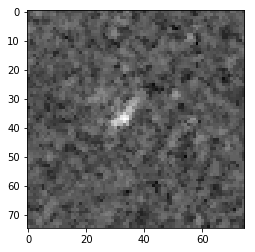

-20.5924959525 -26.3152706819
-20.9089736802 -26.3424093745
---------------------


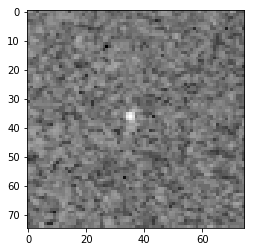

-20.5555859822 -26.2668042583
-21.0564985772 -26.5361240829
---------------------


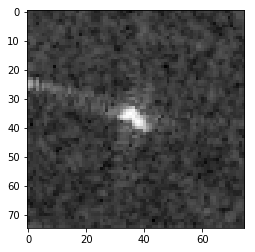

-20.746692724 -26.3556690682
-20.2926669581 -26.1809416808
---------------------


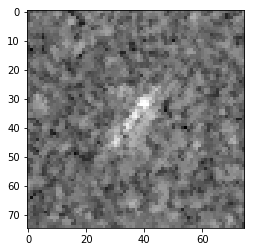

-20.7548667019 -26.3664355651
-20.2584500413 -26.1371950891
---------------------


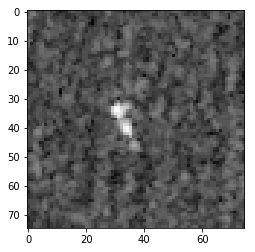

In [443]:
kfold = 5
kfold_scores = []

test_dataset = icebergDataset(X_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

results = []
sss = KFold(n_splits=kfold, random_state=0)
temp = []
for i, (train_index, test_index) in enumerate(sss.split(X_KF[0], X_KF[1], y_KF)):
    X_train_KF, X_valid_KF = [X_KF[0][train_index], X_KF[1][train_index]], [X_KF[0][test_index], X_KF[1][test_index]]
    y_train_KF, y_valid_KF = y_KF[train_index], y_KF[test_index]
    
    print(np.mean(X_train_KF[0][:,0,:,:]), np.mean(X_train_KF[0][:,1,:,:]))
    print(np.mean(X_valid_KF[0][:,0,:,:]), np.mean(X_valid_KF[0][:,1,:,:]))
    print('---------------------')
    
    num = np.random.randint(len(X_valid_KF[0]))
    plt.imshow(X_valid_KF[0][num,0,:,:],cmap='gray')
    plt.show()